## Import google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## OS path for Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input/palm-tree-detection-dataset/Palm Tree Detection Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Model Training

### Import palm tree dataset and annotation file

In [ ]:
#!pip install torchvision

In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class PalmTreeDataset(Dataset):
    def __init__(self, coco_annotation_file, image_dir, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms

        # Load COCO annotations
        with open(coco_annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Index images and annotations
        self.images = {img['id']: img for img in self.coco_data['images']}
        self.annotations = self.coco_data['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image information
        image_info = self.images[idx + 1]  # COCO IDs start at 1
        image_path = os.path.join(self.image_dir, image_info['file_name'])

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Get annotations for the image
        image_id = image_info['id']
        annotations = [anno for anno in self.annotations if anno['image_id'] == image_id]

        # Prepare target dictionary
        boxes = []
        labels = []
        for anno in annotations:
            bbox = anno['bbox']
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(anno['category_id'])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id])
        }

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

        return image, target

### file location

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor

# Initialize Dataset and DataLoader
train_dataset = PalmTreeDataset(
    coco_annotation_file='/content/drive/MyDrive/responsible ai/train_annotations.json',
    image_dir='/content/drive/MyDrive/responsible ai/dataset_images',
    transforms=Compose([ToTensor()])
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,  # Adjust batch size as per your GPU memory
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))  # Collate function for variable-sized targets
)

### import Faster RCNN

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_faster_rcnn_model(num_classes):
    # Load model with default COCO weights
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Update the classifier head for the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Instantiate the model
model = get_faster_rcnn_model(num_classes=2)  # 2 classes: background + palm_tree

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 119MB/s]


### model training

In [ ]:
import torch
import os

# Training setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Directory to save models
save_dir = '/content/drive/MyDrive/responsible ai/MODEL_CHECKPOINTS'
os.makedirs(save_dir, exist_ok=True)

# Training loop
num_epochs = 20  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the model after each epoch
    model_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")


'import torch\nimport os\n\n# Training setup\ndevice = torch.device(\'cuda\') if torch.cuda.is_available() else torch.device(\'cpu\')\nmodel.to(device)\noptimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)\n\n# Directory to save models\nsave_dir = \'/content/drive/MyDrive/responsible ai/MODEL_CHECKPOINTS\'\nos.makedirs(save_dir, exist_ok=True)\n\n# Training loop\nnum_epochs = 20  # Adjust as needed\nfor epoch in range(num_epochs):\n    model.train()\n    epoch_loss = 0\n\n    for images, targets in train_loader:\n        images = [img.to(device) for img in images]\n        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]\n\n        loss_dict = model(images, targets)\n        losses = sum(loss for loss in loss_dict.values())\n\n        optimizer.zero_grad()\n        losses.backward()\n        optimizer.step()\n\n        epoch_loss += losses.item()\n\n    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")\n\n    # 

### Palm tree detection using resnet50

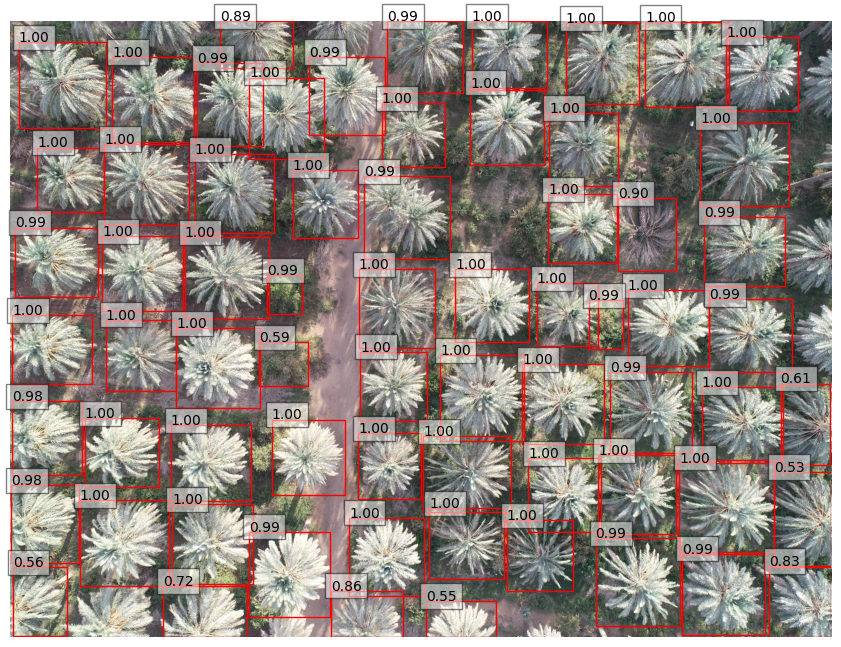

In [ ]:
# Import necessary libraries
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Define prediction function
def predict(image_path, model, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = ToTensor()(image).to(device)

    with torch.no_grad():
        prediction = model([image_tensor])
    return prediction[0]

# Define visualization function
def visualize_predictions(image_path, predictions, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box, score in zip(predictions['boxes'], predictions['scores']):
        if score < threshold:
            continue
        xmin, ymin, xmax, ymax = box.tolist()
        width, height = xmax - xmin, ymax - ymin

        # Add bounding box
        rect = patches.Rectangle(
            (xmin, ymin), width, height, linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        # Add score
        ax.text(xmin, ymin - 5, f"{score:.2f}", color='black', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # Assuming 2 classes: background + palm_tree
model.load_state_dict(torch.load('/content/drive/MyDrive/responsible ai/MODEL_CHECKPOINTS/model_epoch_14.pth', map_location=device))
model.to(device)

# Test the model with an example image
test_image_path = '/content/drive/MyDrive/responsible ai/test/ck2gc6eaggd4m0748e86tcwvm.jpg'  # Path to test image
predictions = predict(test_image_path, model, device)

# Visualize the predictions
visualize_predictions(test_image_path, predictions)


In [ ]:
threshold = 0.5
tree_count_model = sum(score > threshold for score in predictions['scores'])
print(f"Total number of detected palm trees: {tree_count_model}")

Total number of detected palm trees: 67


In [ ]:
# Create test dataset and DataLoader
test_dataset = PalmTreeDataset(
    coco_annotation_file='/content/drive/MyDrive/responsible ai/test_annotations.json',
    image_dir='/content/drive/MyDrive/responsible ai/dataset_images',
    transforms=Compose([ToTensor()])
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

# score

In [ ]:
from torchvision.ops import box_iou

def evaluate_model_on_test_set(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_scores = []
    all_iou = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            outputs = model(images)

            for idx, output in enumerate(outputs):
                # Calculate IoU between predicted and ground-truth boxes
                gt_boxes = targets[idx]['boxes'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    continue

                ious = box_iou(gt_boxes, pred_boxes)
                max_iou, max_idx = ious.max(dim=1)

                # Filter predictions by IoU threshold
                valid_preds = max_iou >= iou_threshold
                correct_predictions += valid_preds.sum().item()
                total_predictions += len(gt_boxes)

                # Store scores and IoU for later analysis
                all_scores.extend(pred_scores.tolist())
                all_iou.extend(max_iou.tolist())

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Accuracy: {accuracy:.2f}")
    print("Accuracy:", accuracy)

    return accuracy, all_scores, all_iou

In [ ]:
accuracy, all_scores, all_iou = evaluate_model_on_test_set(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")

Accuracy: 0.95
Accuracy: 0.9497939303109779
Test Accuracy: 0.9498


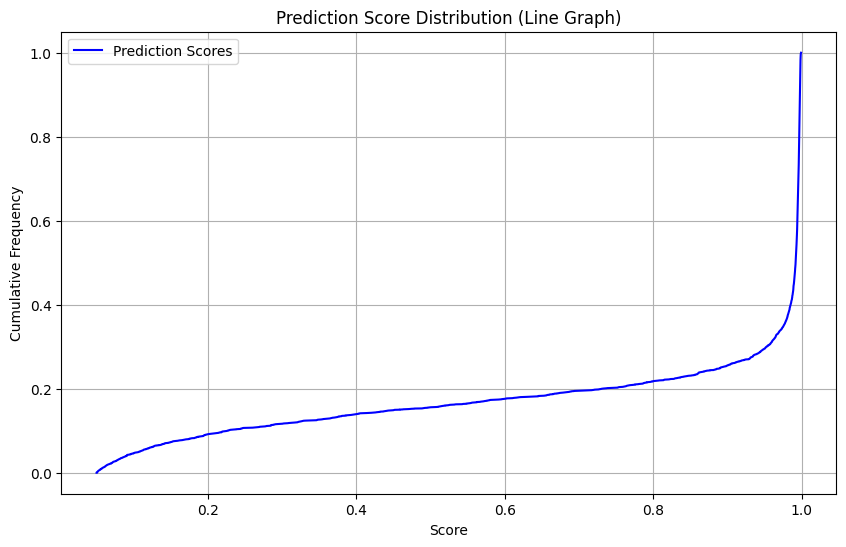

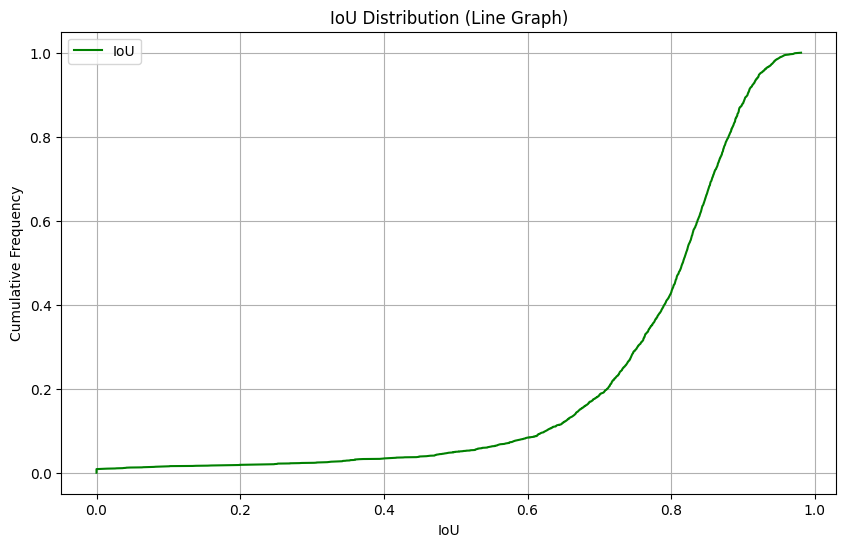

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sort scores for a smooth line plot
sorted_scores = np.sort(all_scores)
sorted_ious = np.sort(all_iou)

# Generate frequency for scores (cumulative distribution function for better clarity)
score_frequencies = np.arange(len(sorted_scores)) / float(len(sorted_scores))
iou_frequencies = np.arange(len(sorted_ious)) / float(len(sorted_ious))

# Plot line graph for prediction scores
plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, score_frequencies, label="Prediction Scores", color='blue')
plt.title("Prediction Score Distribution (Line Graph)")
plt.xlabel("Score")
plt.ylabel("Cumulative Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Plot line graph for IoU
plt.figure(figsize=(10, 6))
plt.plot(sorted_ious, iou_frequencies, label="IoU", color='green')
plt.title("IoU Distribution (Line Graph)")
plt.xlabel("IoU")
plt.ylabel("Cumulative Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Grad-cam

In [ ]:
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import cv2

# Load a pretrained classifier model (you can replace this with your trained palm tree classifier)
classifier = models.resnet18(pretrained=True)
classifier.eval()
target_layer = classifier.layer4[-1]

# Hooks to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Grad-CAM function
def compute_gradcam(image_crop_pil):
    activations.clear()
    gradients.clear()

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(image_crop_pil).unsqueeze(0)
    output = classifier(input_tensor)
    class_idx = output.argmax(dim=1).item()

    classifier.zero_grad()
    output[0, class_idx].backward()

    grad = gradients[0]
    act = activations[0]
    weights = grad.mean(dim=(2, 3), keepdim=True)

    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
    cam = cam.squeeze().detach().numpy()

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    return cam


In [ ]:
def visualize_predictions_with_gradcam(image_path, predictions, threshold=0.8):
    from matplotlib import gridspec  # for flexible layout

    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    image_overlay = image_np.copy()

    tree_count = sum(score > threshold for score in predictions['scores'])

    tree_count = 0
    YIELD_PER_TREE_KG = 85

    for box, score in zip(predictions['boxes'], predictions['scores']):
        if score < threshold:
            continue

        tree_count += 1
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        crop_pil = image.crop((xmin, ymin, xmax, ymax))
        cam = compute_gradcam(crop_pil)
        cam_resized = cv2.resize(cam, (xmax - xmin, ymax - ymin))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        blend = (0.5 * image_overlay[ymin:ymax, xmin:xmax] + 0.5 * heatmap).astype(np.uint8)
        image_overlay[ymin:ymax, xmin:xmax] = blend

    # Draw bounding boxes and scores on the overlay image
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(2, 2, height_ratios=[20, 1])

    # Original image
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.imshow(image_np)
    ax1.set_title("Original Image", fontsize=14)
    ax1.axis('off')

    # Grad-CAM image with boxes
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.imshow(image_overlay)

    for box, score in zip(predictions['boxes'], predictions['scores']):
        if score < threshold:
            continue
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='red', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(xmin, ymin - 5, f"{score:.2f}", color='black', fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title("Grad-CAM", fontsize=14)
    ax2.axis('off')

    # Bottom text
    estimated_production_kg = tree_count * YIELD_PER_TREE_KG
    subtitle = f"Estimated Trees = {tree_count} | Estimated Production = {estimated_production_kg} kg"

    ax_text = fig.add_subplot(spec[1, :])
    ax_text.axis('off')
    ax_text.text(0.5, 0.5, subtitle, fontsize=16, ha='center',
                 bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


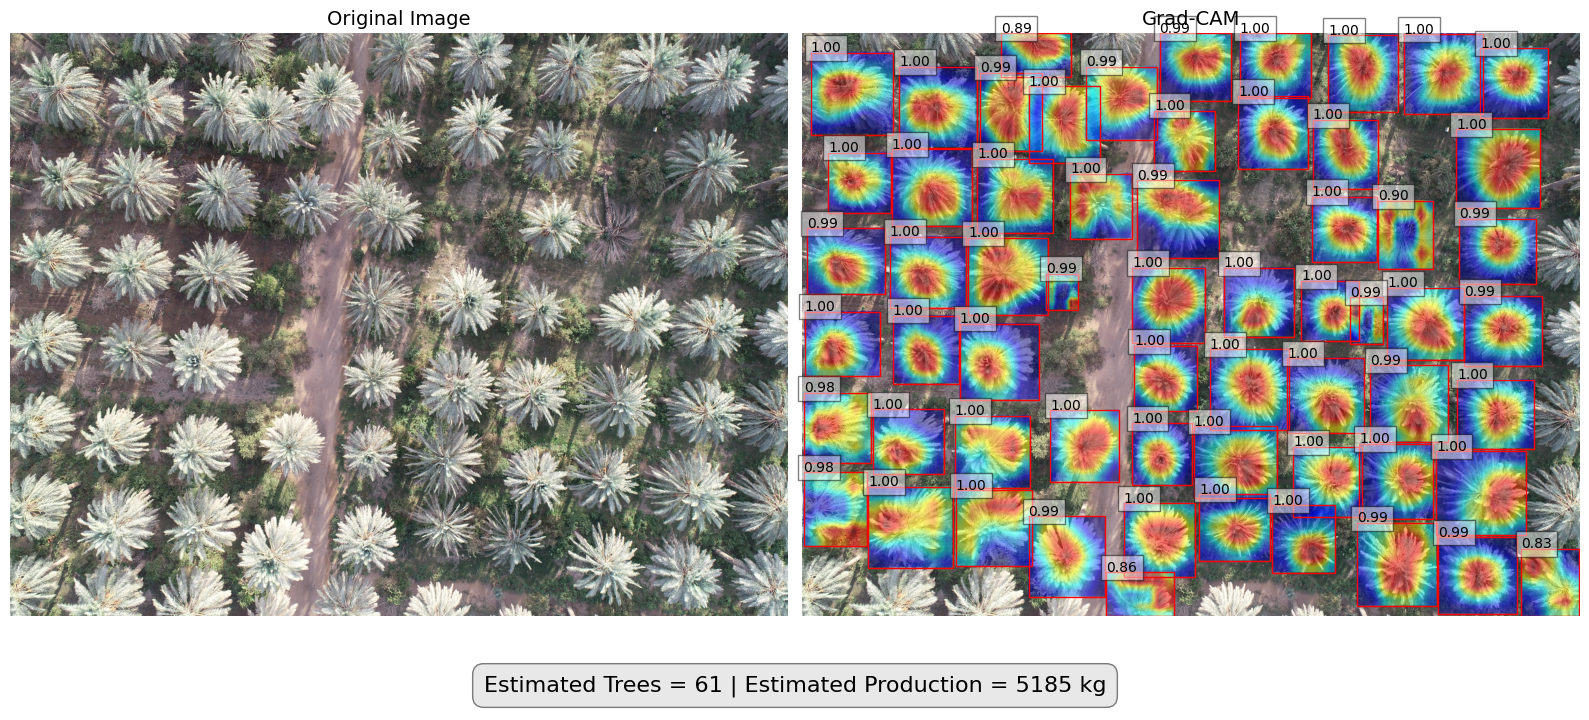

In [ ]:
visualize_predictions_with_gradcam(test_image_path, predictions)

In [1]:
 ! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [2]:
!wget -q -O - ipv4.icanhazip.com

34.169.33.167


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
⠙⠹⠸⠼⠴your url is: https://cold-clowns-kick.loca.lt
